In [223]:
import pylab as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin,BaseEstimator
from datetime import datetime
from datetime import date
import scipy.stats as stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_palette("mako")

### Načítanie a čistenie dát

In [224]:
stations= pd.read_csv("data/stations.csv", sep="\t")
measurements= pd.read_csv("data/measurements.csv", sep="\t")

In [225]:
measurements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12128 entries, 0 to 12127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       12080 non-null  float64
 1   PM10       12079 non-null  float64
 2   C2H3NO5    12079 non-null  float64
 3   O3         12079 non-null  float64
 4   NH3        12080 non-null  float64
 5   Pb         12079 non-null  float64
 6   PRES       12128 non-null  float64
 7   CFCs       12079 non-null  float64
 8   longitude  12128 non-null  float64
 9   SO2        12079 non-null  float64
 10  latitude   12128 non-null  float64
 11  NOx        12078 non-null  float64
 12  warning    12079 non-null  float64
 13  CO         12079 non-null  float64
 14  CH4        12079 non-null  float64
 15  PM2.5      12080 non-null  float64
 16  H2CO       12080 non-null  float64
 17  TEMP       12080 non-null  float64
dtypes: float64(18)
memory usage: 1.7 MB


In [226]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    1051 non-null   object 
 1   latitude   1051 non-null   float64
 2   code       1050 non-null   object 
 3   revision   1051 non-null   object 
 4   QoS        1051 non-null   object 
 5   longitude  1051 non-null   float64
dtypes: float64(2), object(4)
memory usage: 49.4+ KB


Skontrolujeme, či sú jednotlivé 'latitude' jedinečné, a podľa nich joineme.

In [227]:
latitude_s = stations["latitude"].unique().sort()
latitude_m = measurements["latitude"].unique().sort()
np.array_equal(latitude_s, latitude_m)

True

Sú rovnaké, preto môžeme ich spojiť.
Odstránime QoS, revision a code, keďže tieto parametre neovplyvňujú kvalitu ovzdušia.Taktiež odstránime duplicitný stĺpec ktorý nám vznikne.

In [228]:
stations.drop(columns=["QoS"], inplace=True)
stations.drop(columns=["revision"], inplace=True)
stations.drop(columns=["code"], inplace=True)
data = pd.merge(measurements, stations, on = ["latitude"], how = "left")
data.drop(columns=["longitude_x"], inplace=True)
data.rename(columns={'longitude_y': 'longitude'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25540 entries, 0 to 25539
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       25447 non-null  float64
 1   PM10       25437 non-null  float64
 2   C2H3NO5    25444 non-null  float64
 3   O3         25435 non-null  float64
 4   NH3        25448 non-null  float64
 5   Pb         25435 non-null  float64
 6   PRES       25540 non-null  float64
 7   CFCs       25447 non-null  float64
 8   SO2        25434 non-null  float64
 9   latitude   25540 non-null  float64
 10  NOx        25443 non-null  float64
 11  warning    25427 non-null  float64
 12  CO         25437 non-null  float64
 13  CH4        25442 non-null  float64
 14  PM2.5      25434 non-null  float64
 15  H2CO       25443 non-null  float64
 16  TEMP       25438 non-null  float64
 17  station    25540 non-null  object 
 18  longitude  25540 non-null  float64
dtypes: float64(18), object(1)
memory usage: 3.9+ M

Ukážka dát po spojení.

In [229]:
data.head()

,PAHs,PM10,C2H3NO5,O3,NH3,Pb,PRES,CFCs,SO2,latitude,NOx,warning,CO,CH4,PM2.5,H2CO,TEMP,station,longitude
0,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,10.31364,0.0,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,144.23058
1,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,10.31364,0.0,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,144.23058
2,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,10.31364,0.0,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,144.23058
3,10.39372,8.25541,1.19707,8.98772,9.82297,47.15361,1063.43896,69.62954,8.29285,8.88649,10.26103,0.0,8.47772,9.60717,7.09990,65.37280,13.19832,Tchaourou,2.59753
4,9.56441,8.43278,1.32137,4.43270,8.08426,47.94224,1111.55551,77.84035,8.42276,10.10649,6.11983,1.0,8.97045,8.89398,8.22953,47.62991,3.92248,Alwaye,76.35484


Odstránime duplicitné záznamy

In [230]:
tmp = data.duplicated()
tmp = tmp[tmp == True].count()
print('Počet duplicitných záznamov: '+ str(tmp))

Počet duplicitných záznamov: 13591


In [231]:
data = data.drop_duplicates()
tmp = data.duplicated()
tmp = tmp[tmp == True].count()
print('Počet duplicitných záznamov: '+ str(tmp))

Počet duplicitných záznamov: 0


In [232]:
data.describe()

,PAHs,PM10,C2H3NO5,O3,NH3,Pb,PRES,CFCs,SO2,latitude,NOx,warning,CO,CH4,PM2.5,H2CO,TEMP,longitude
count,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11949.00000,11901.000000,11901.000000,11949.000000,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11949.000000
mean,8.793407,8.795797,3.346339,9.315354,8.802845,49.793778,1125.26050,72.087720,8.815813,28.522628,9.316578,0.595664,8.800033,9.312754,8.780025,50.788099,14.925675,8.634207
std,2.075479,0.991844,4.069032,1.906690,0.993455,12.757519,43.27262,7.170915,1.946974,23.364543,1.692003,0.490784,1.002546,1.904321,2.078473,13.924619,9.950045,72.929082
min,1.925340,5.187260,0.000000,2.048720,5.124910,0.000000,1050.00071,0.000000,1.029620,-54.800000,2.304540,0.000000,5.032870,2.492000,0.000000,0.000000,-26.219360,-156.474320
25%,7.339640,8.130800,1.198020,8.123430,8.129190,41.236540,1087.74162,67.287060,7.425060,13.701670,8.381980,0.000000,8.126820,8.034840,7.307000,41.500110,8.169370,-67.154070
50%,8.856240,8.792160,2.135070,9.473560,8.802850,49.716590,1125.78376,72.132440,8.989670,36.208290,9.640500,1.000000,8.808710,9.426420,8.628970,50.682700,14.908990,7.227800
75%,10.276030,9.462440,3.938000,10.662760,9.460690,58.356560,1162.63878,76.898340,10.213520,45.040800,10.487290,1.000000,9.474830,10.651500,10.259350,60.117480,21.692530,68.888710
max,17.068470,12.750440,100.000000,15.619060,12.763030,100.000000,1199.97470,100.000000,15.856800,68.798330,14.915300,1.000000,12.576710,16.569680,16.646230,100.000000,52.722610,178.004170


Presunieme si latitude a longtitude na koniec, aby sme vedeli neskôr ľahšie vyberať parametre ovplyvňujúce kvalitu ovzdušia.

In [233]:
data.insert(16, 'latitude', data.pop('latitude'))
data.insert(17, 'longitude', data.pop('longitude'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11949 entries, 0 to 25539
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       11901 non-null  float64
 1   PM10       11901 non-null  float64
 2   C2H3NO5    11901 non-null  float64
 3   O3         11901 non-null  float64
 4   NH3        11901 non-null  float64
 5   Pb         11901 non-null  float64
 6   PRES       11949 non-null  float64
 7   CFCs       11901 non-null  float64
 8   SO2        11901 non-null  float64
 9   NOx        11901 non-null  float64
 10  warning    11901 non-null  float64
 11  CO         11901 non-null  float64
 12  CH4        11901 non-null  float64
 13  PM2.5      11901 non-null  float64
 14  H2CO       11901 non-null  float64
 15  TEMP       11901 non-null  float64
 16  latitude   11949 non-null  float64
 17  longitude  11949 non-null  float64
 18  station    11949 non-null  object 
dtypes: float64(18), object(1)
memory usage: 1.8+ M

### Odstránenie NA hodnôt
Ako prvé skúsime metódu s odstránením riadkov, kde chýbajú hodnoty.

In [234]:
tmp_data = data.copy()
tmp_data.dropna(inplace=True)

In [235]:
len(data) - len(tmp_data)

702

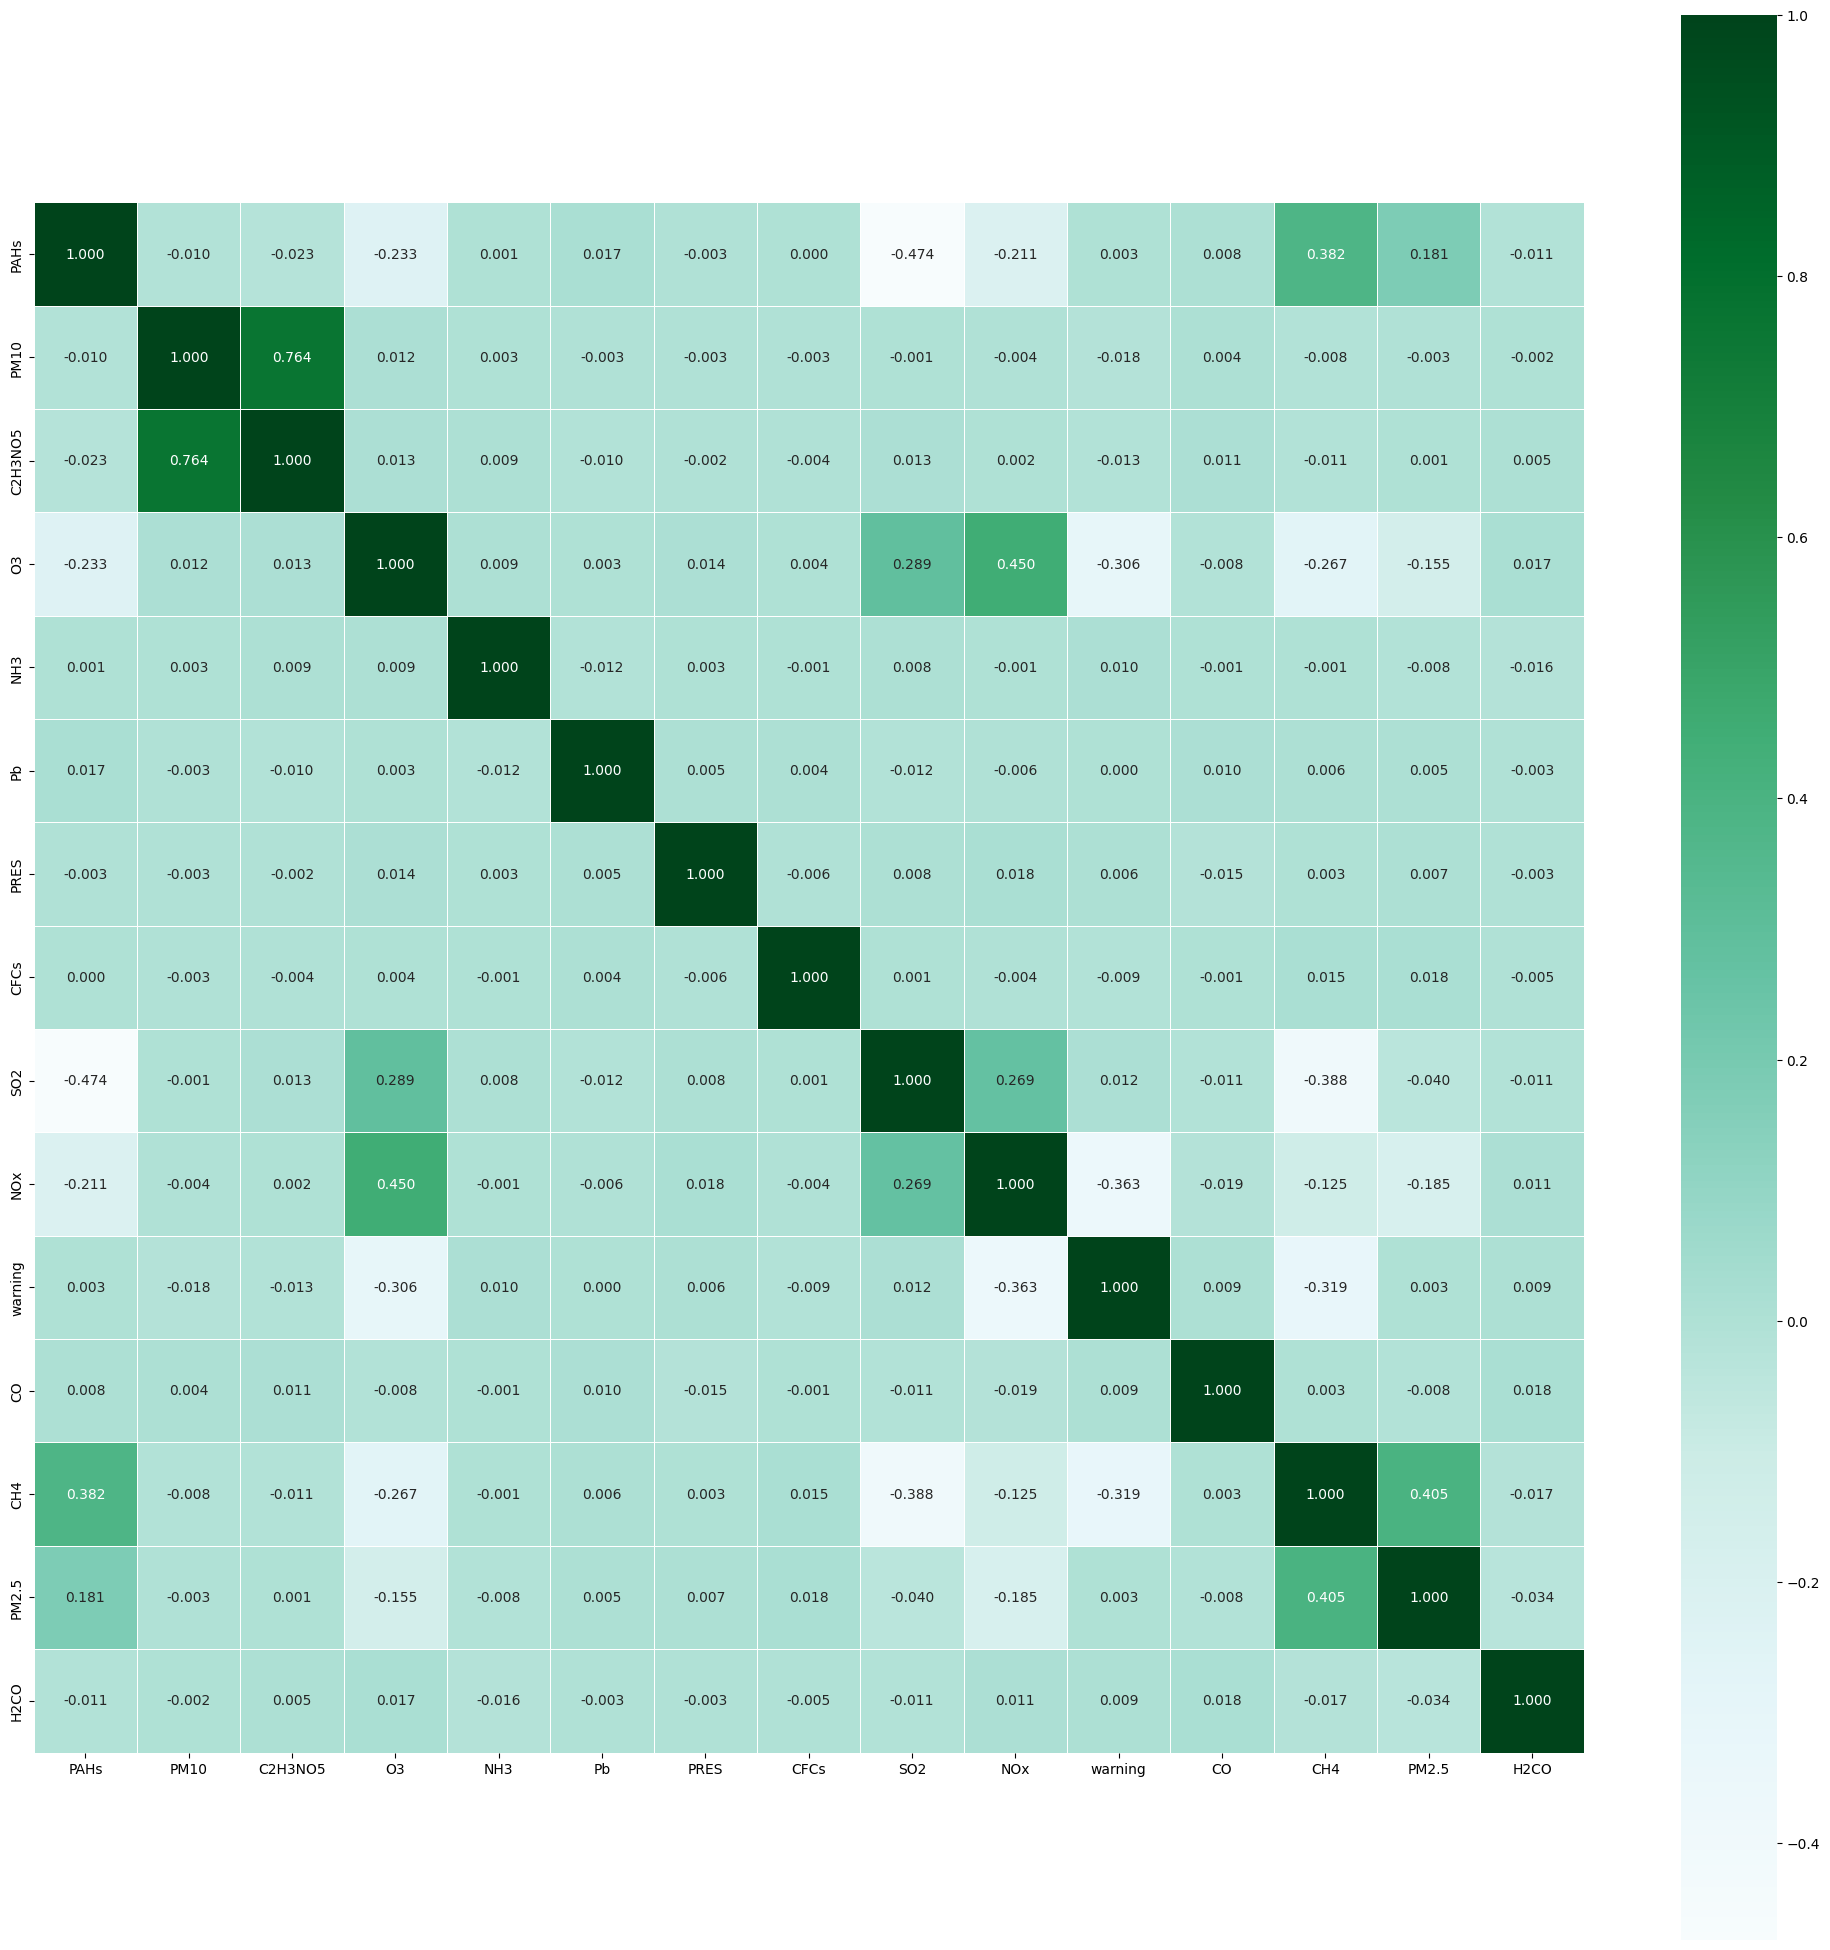

In [236]:
plt.figure(figsize=(25,25))
sns.heatmap(data.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

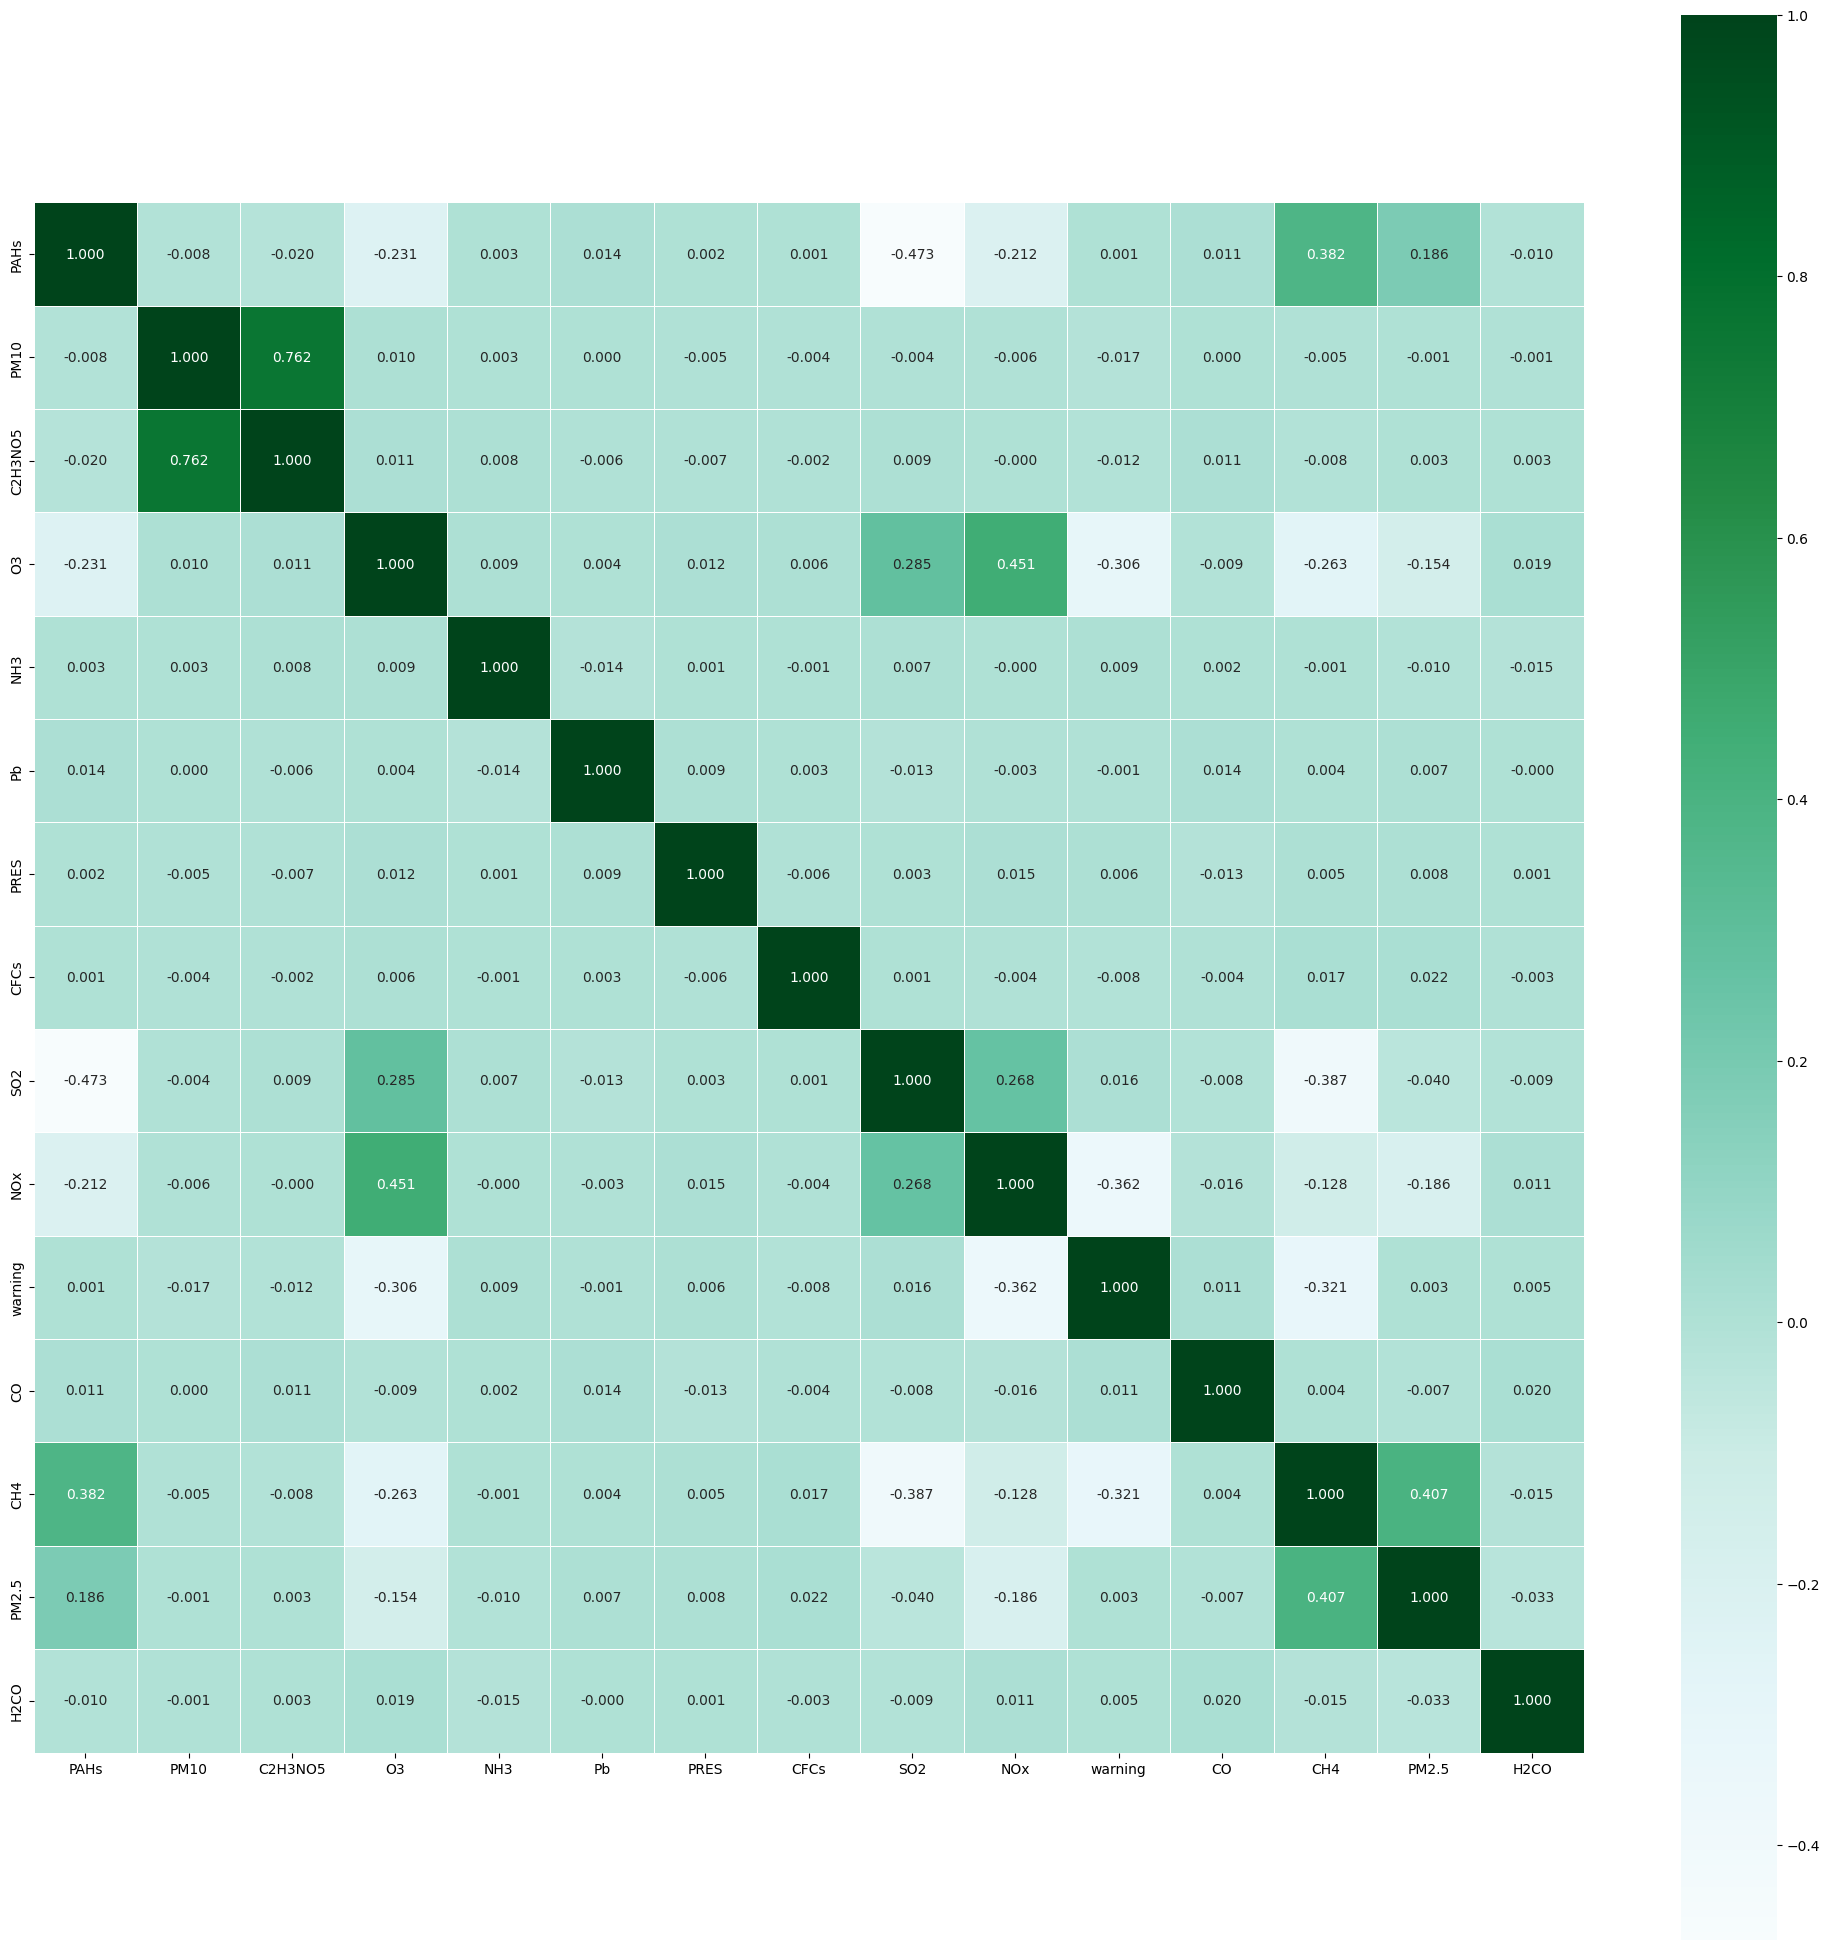

In [237]:
plt.figure(figsize=(25,25))
sns.heatmap(tmp_data.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

Vytvorenie pomocnej funkcie na výpočet korelácie s pôvodnými dátami.

In [238]:
def findDiffCorrelation(tmp_data):
    return (tmp_data.iloc[: , :15].corr() - data.iloc[: , :15].corr()).max()


Výpočet korelácie metódou zmananím.

In [239]:
findDiffCorrelation(tmp_data)

PAHs       0.004701
PM10       0.003223
C2H3NO5    0.003706
O3         0.003947
NH3        0.002657
Pb         0.004447
PRES       0.004701
CFCs       0.003178
SO2        0.004270
NOx        0.003131
warning    0.004270
CO         0.004447
CH4        0.003947
PM2.5      0.004349
H2CO       0.004181
dtype: float64

Výhodou tohto prístupu je, že sa nám heatmapa zmenila len minimálne. Nevýhodou je, že nám zmizlo 702 záznamov.
To nám predstavuje 5.87% dát.

In [240]:
(len(data)-len(tmp_data))/(len(data)) * 100

5.874968616620638

2. metóda je nahradenie N/A hodnôt mediánom 

In [267]:
temp_data_median = data.copy()
temp_data_median.fillna(temp_data_median.iloc[: , :15].median(), inplace=True)
print("Rozdiel v korelácii po nahradení chýbajúcich hodnôt mediánom")
findDiffCorrelation(temp_data_median)

Rozdiel v korelácii po nahradení chýbajúcich hodnôt mediánom


PAHs       0.0
PM10       0.0
C2H3NO5    0.0
O3         0.0
NH3        0.0
Pb         0.0
PRES       0.0
CFCs       0.0
SO2        0.0
NOx        0.0
warning    0.0
CO         0.0
CH4        0.0
PM2.5      0.0
H2CO       0.0
dtype: float64

Vykreslíme si heatmapu

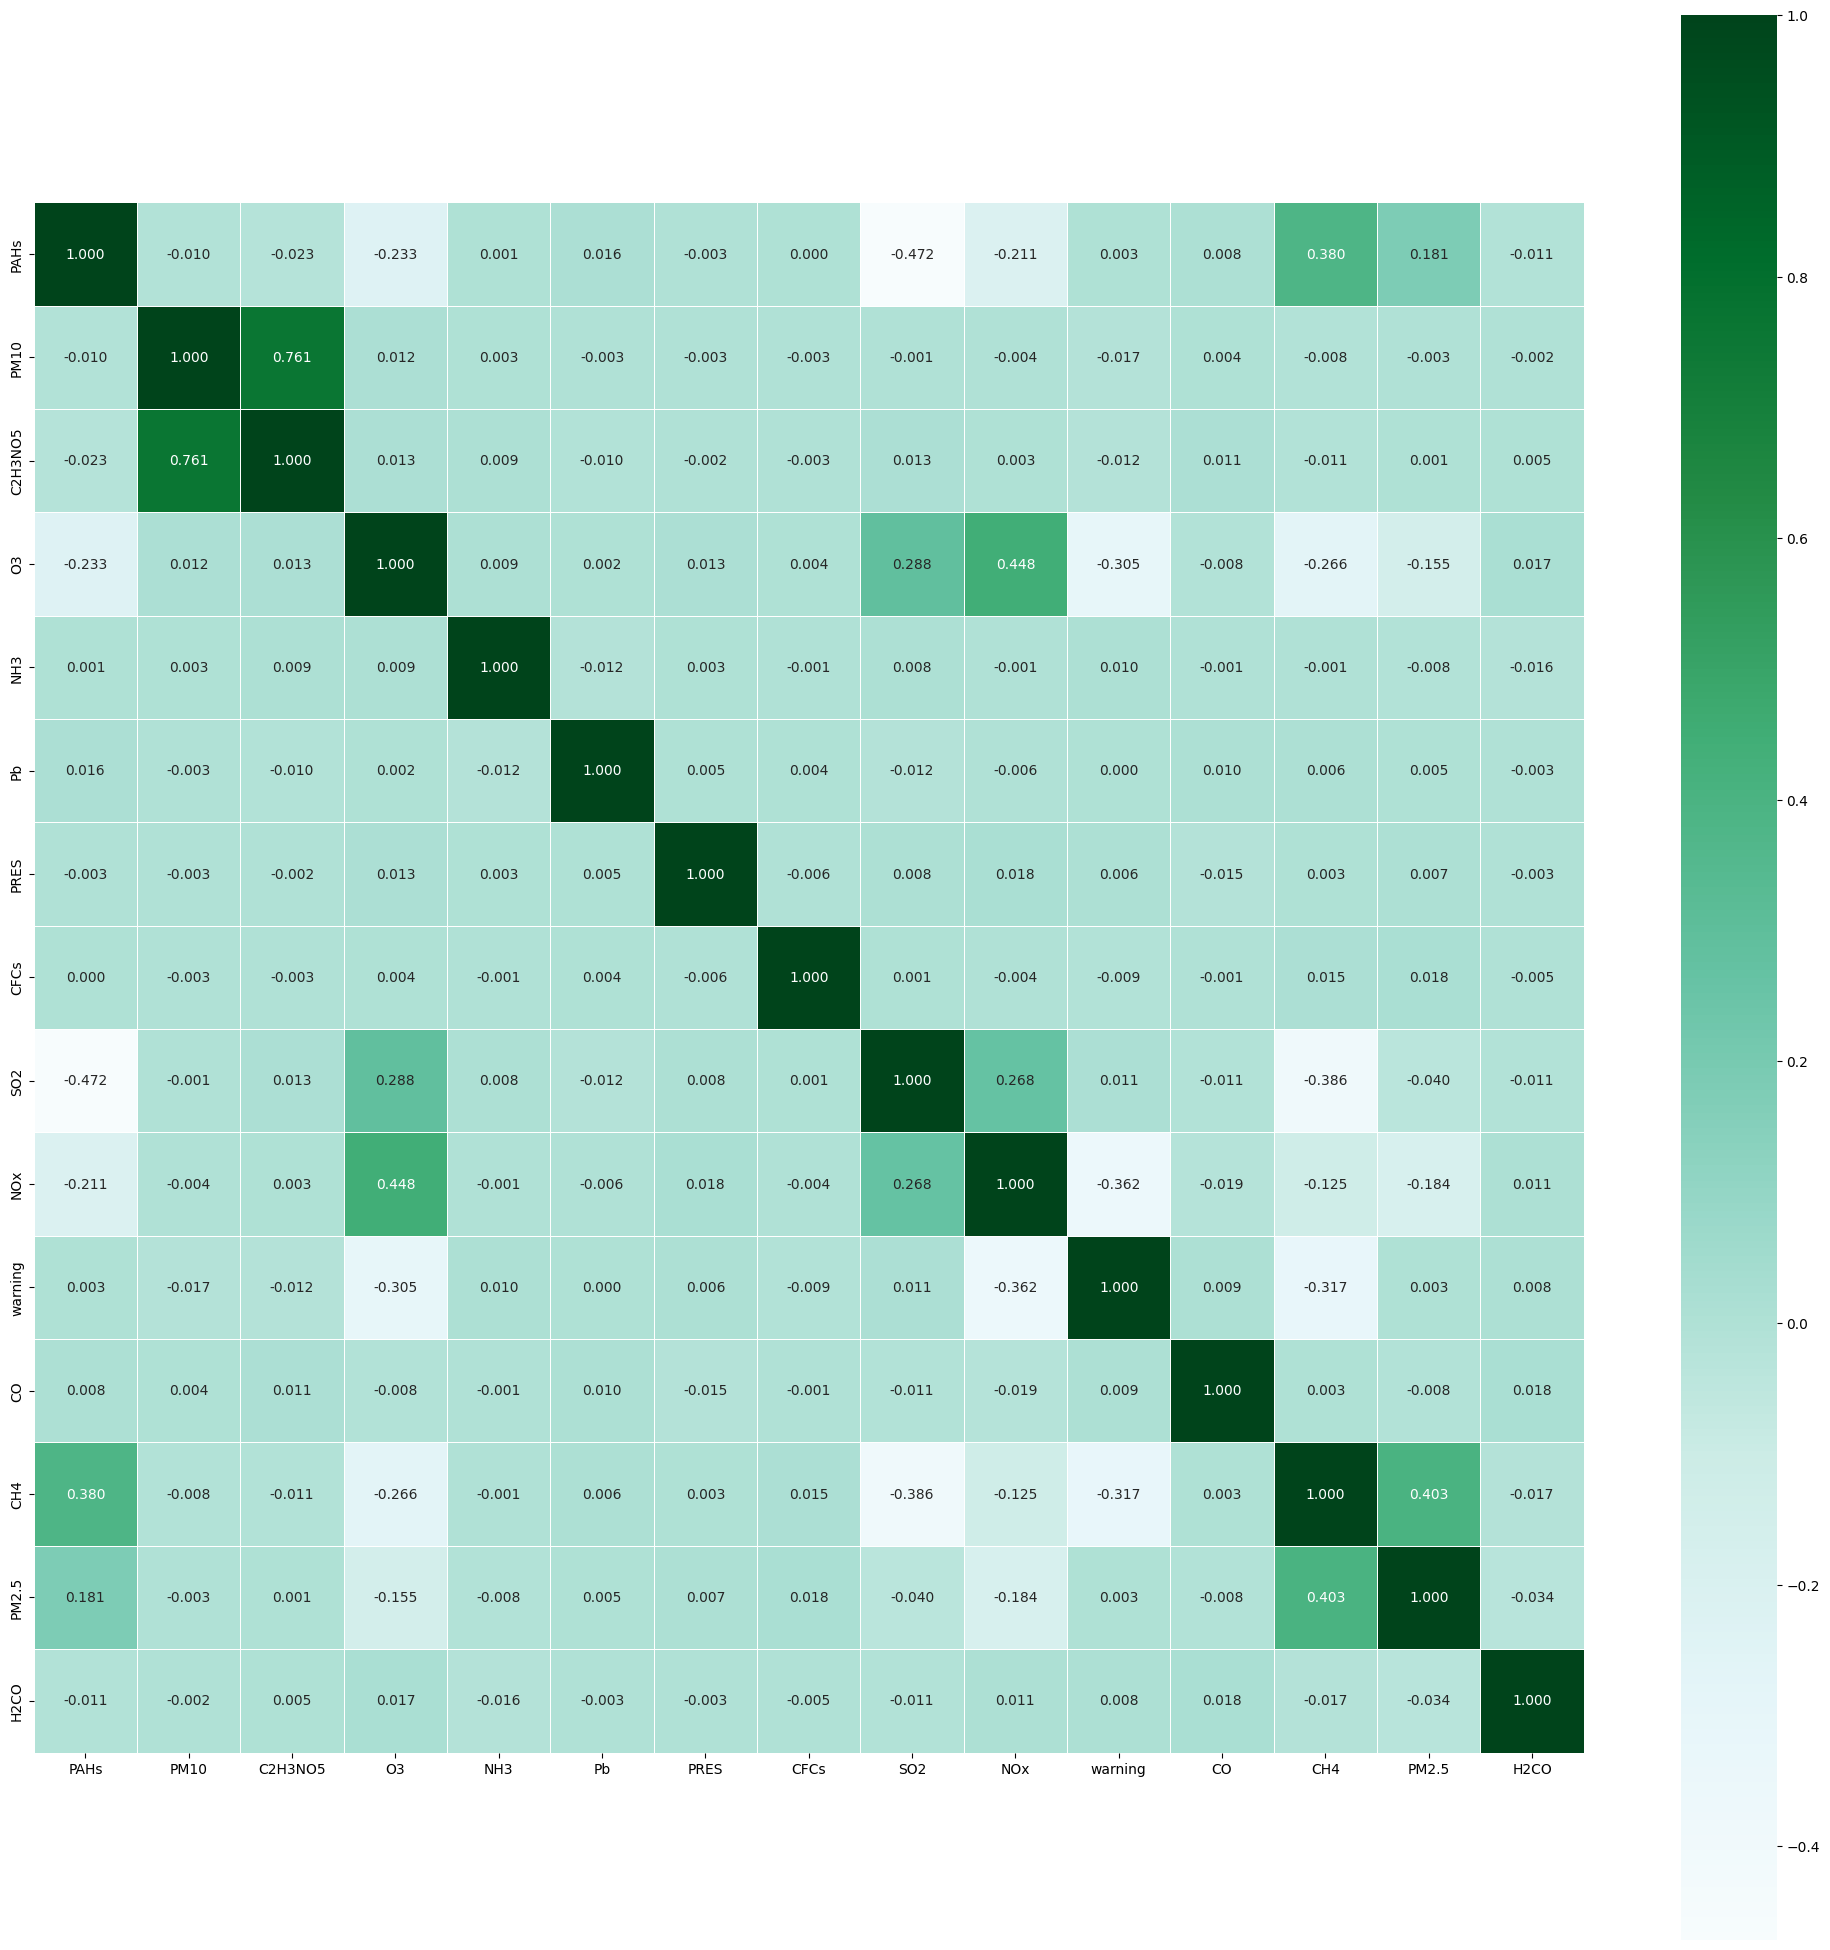

In [258]:
plt.figure(figsize=(25,25))
sns.heatmap(temp_data_median.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

3.Nahradenie chýbajúcich hodnôt priemerom


In [268]:
tmp_data_average = data.copy()
tmp_data_average.fillna(tmp_data_average.iloc[: , :1].mean(), inplace=True)
print("Rozdiel v korelácii po nahradení chýbajúcich hodnôt priemerom")
findDiffCorrelation(tmp_data_average)

Rozdiel v korelácii po nahradení chýbajúcich hodnôt priemerom


PAHs       0.0
PM10       0.0
C2H3NO5    0.0
O3         0.0
NH3        0.0
Pb         0.0
PRES       0.0
CFCs       0.0
SO2        0.0
NOx        0.0
warning    0.0
CO         0.0
CH4        0.0
PM2.5      0.0
H2CO       0.0
dtype: float64

Vykreslíme si heatmapu

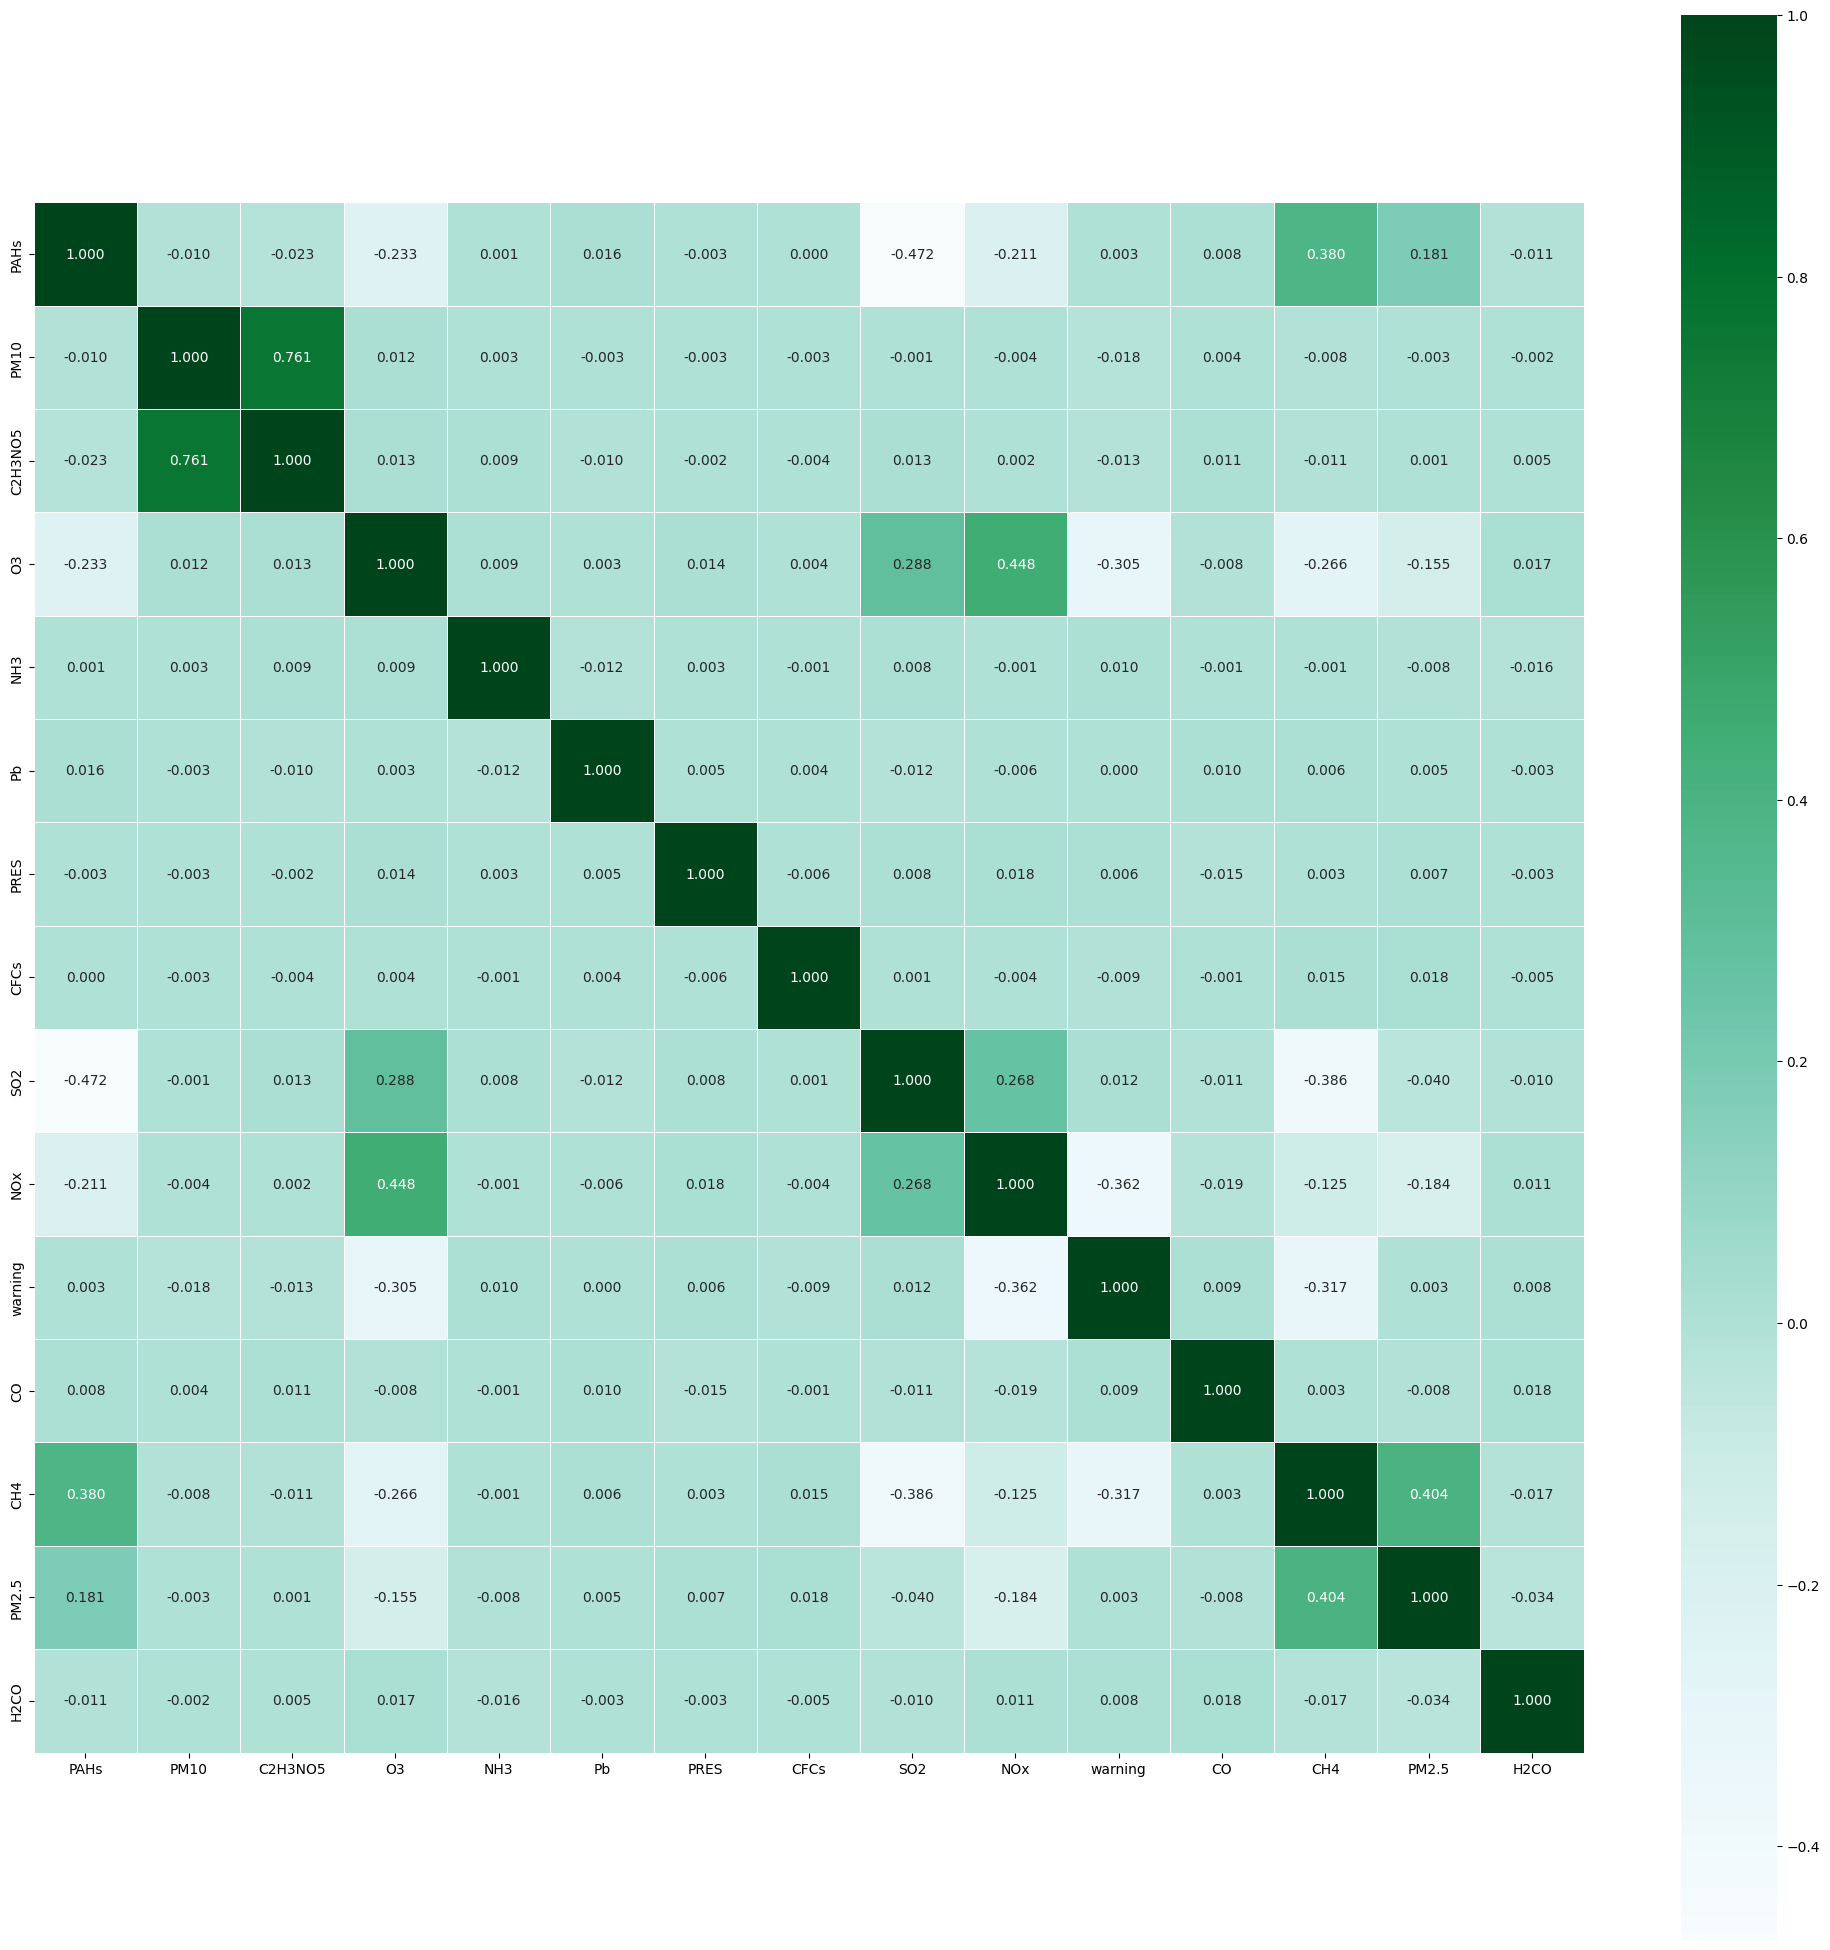

In [259]:
plt.figure(figsize=(25,25))
sns.heatmap(tmp_data_average.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

In [264]:
tmp_data_knn = data.copy()
imputer = KNNImputer(n_neighbors=2)
tmp_data_measurements = tmp_data_knn.iloc[:, :15]
tmp_data_measurements = imputer.fit_transform(tmp_data_measurements)
tmp_data_knn.iloc[:, :15] = tmp_data_measurements
print("Rozdiel v korelácii po nahradení chýbajúcich hodnôt kNN")
findDiffCorrelation(tmp_data_knn)


Rozdiel v korelácii po nahradení chýbajúcich hodnôt kNN


PAHs       0.0
PM10       0.0
C2H3NO5    0.0
O3         0.0
NH3        0.0
Pb         0.0
PRES       0.0
CFCs       0.0
SO2        0.0
NOx        0.0
warning    0.0
CO         0.0
CH4        0.0
PM2.5      0.0
H2CO       0.0
dtype: float64

Vykreslíme si heatmapu

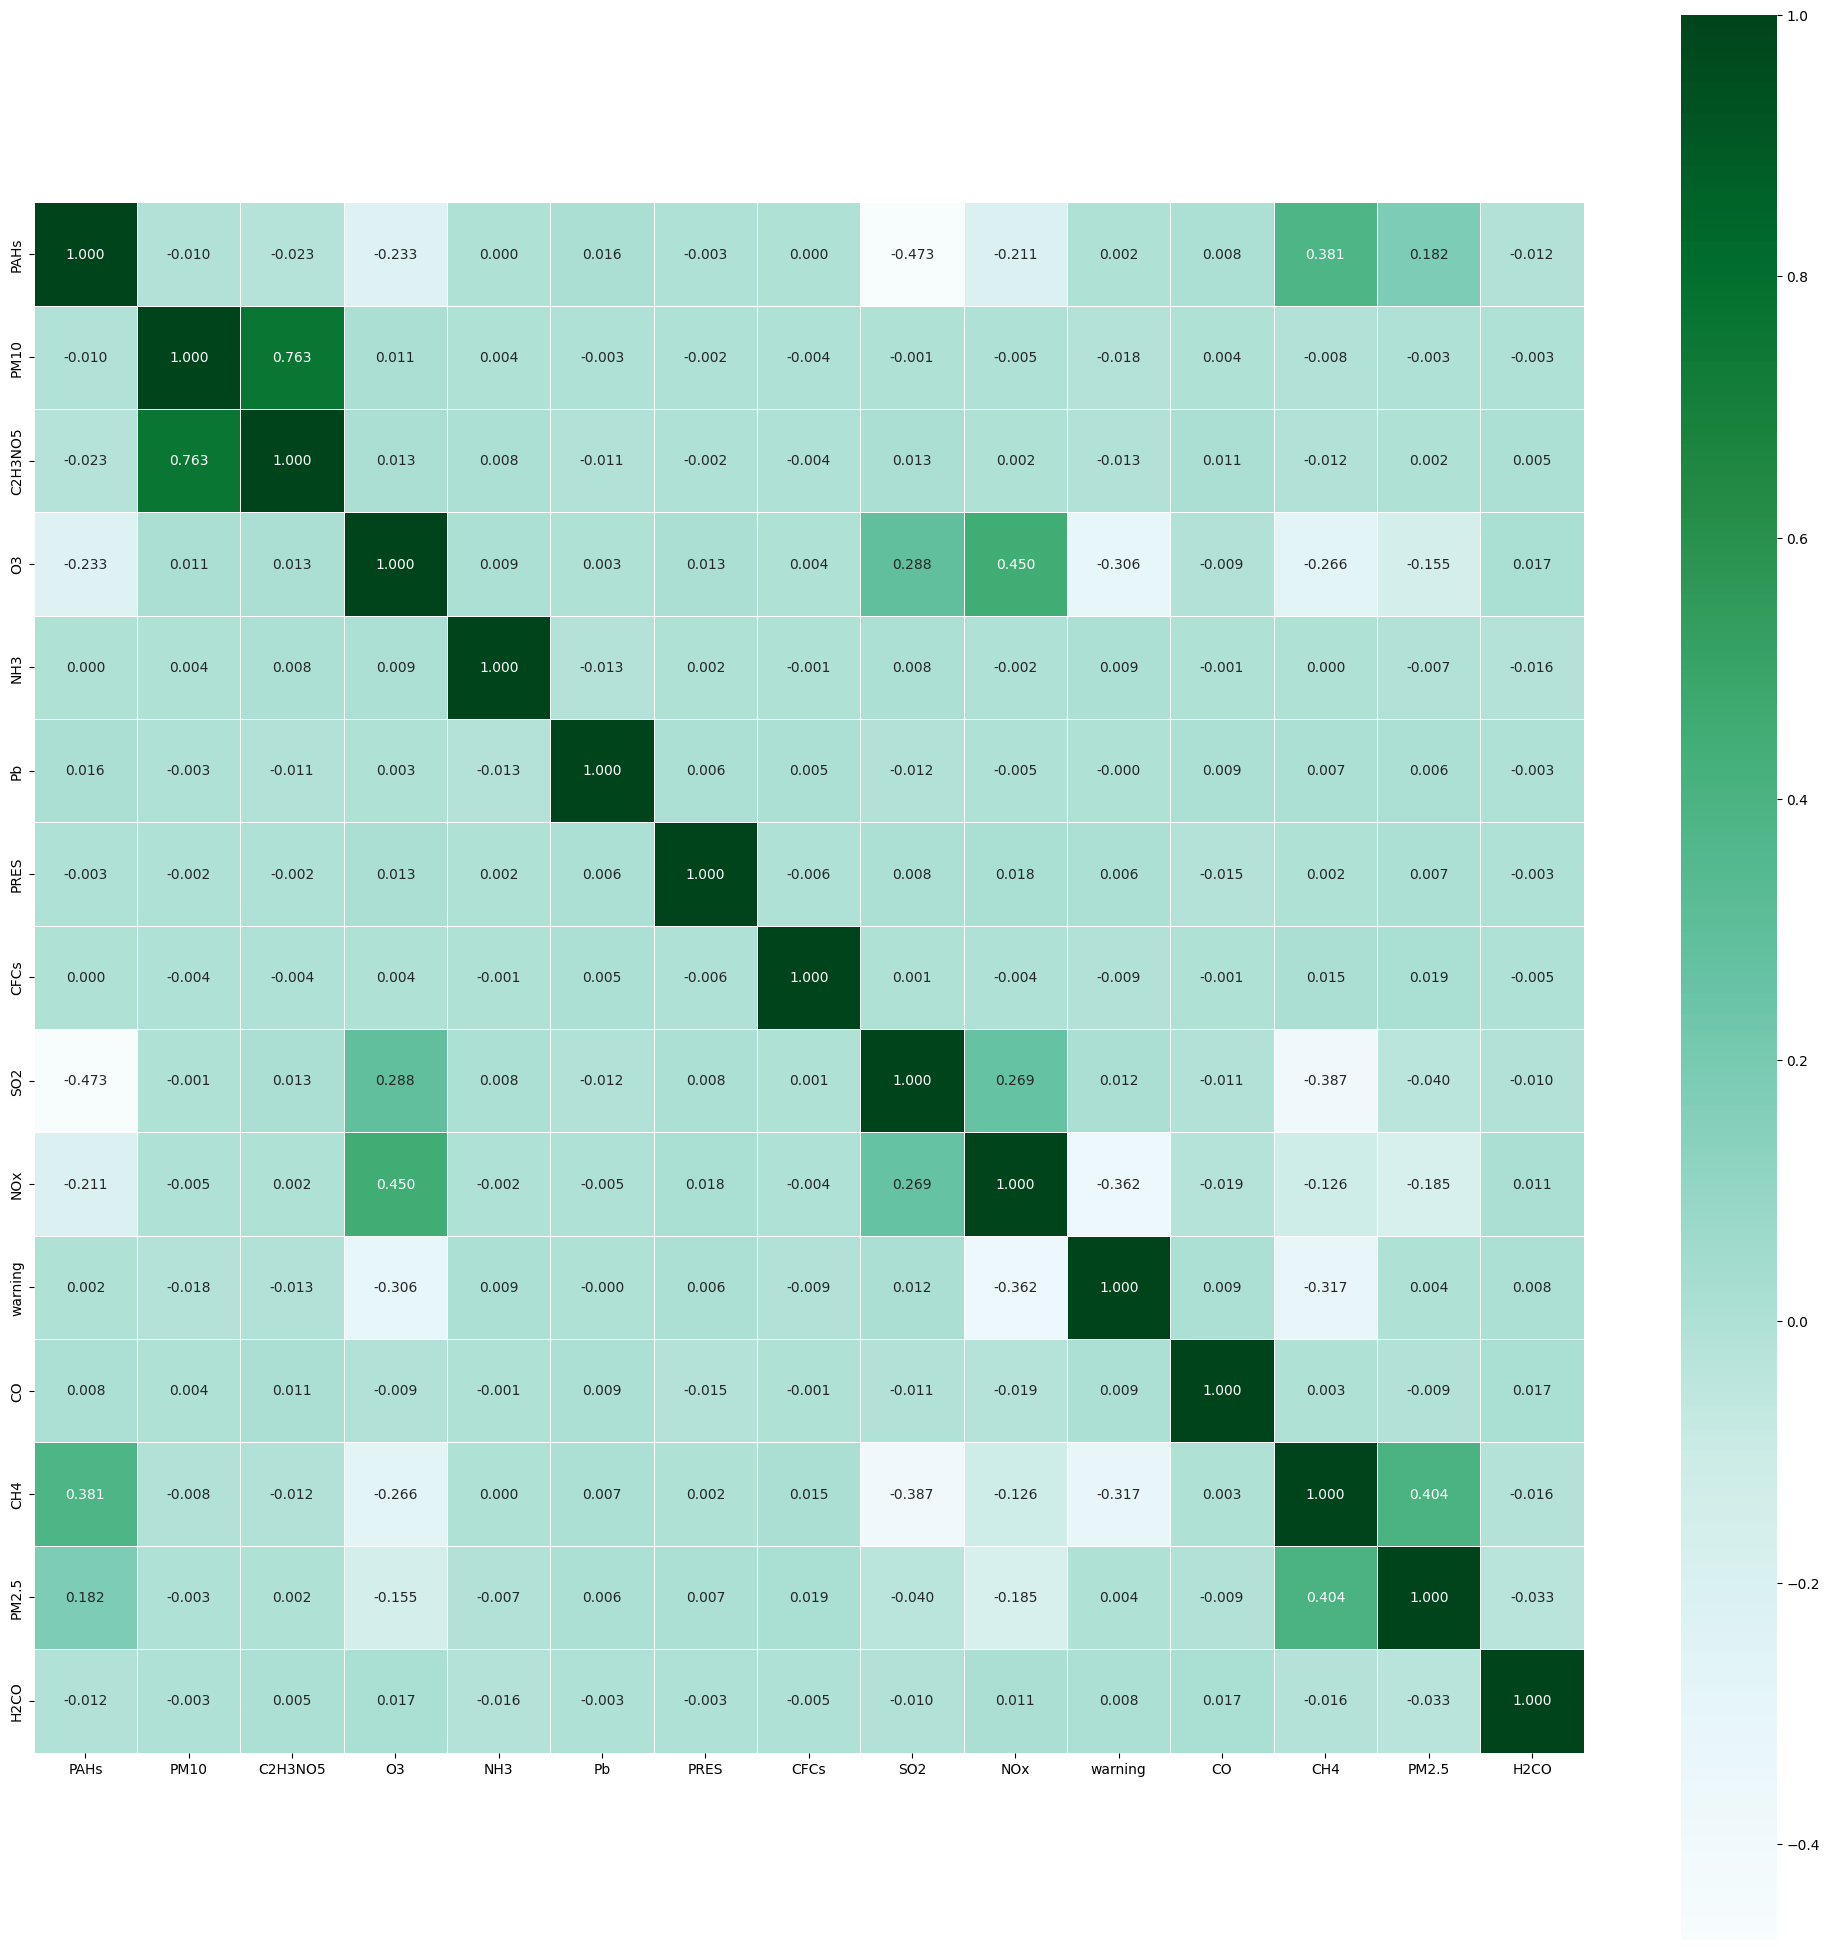

In [260]:
plt.figure(figsize=(25,25))
sns.heatmap(tmp_data_knn.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

Nájdeme, ktorá z metód bola najefektívnejšia

In [254]:
diff_corr_median = abs(temp_data_median.iloc[: , :15].corr() - data.iloc[: , :15].corr()).mean().mean()
diff_corr_average = abs(tmp_data_average.iloc[: , :15].corr() - data.iloc[: , :15].corr()).mean().mean()
diff_corr_knn = abs(tmp_data_knn.iloc[: , :15].corr() - data.iloc[: , :15].corr()).mean().mean()
print("Priemerná odchýlka korelácie od pôvodných dát po nahradení chýbajúcich hodnôt medianom: ", diff_corr_median)
print("Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt priemerom: ", diff_corr_average)
print("Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt kNN: ",diff_corr_knn)
listik = [diff_corr_median,diff_corr_average,diff_corr_knn]
print("Najmenšia odchýlka je:",min(listik))
  

Priemerná odchýlka korelácie od pôvodných dát po nahradení chýbajúcich hodnôt medianom:  0.0003023372218485836
Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt priemerom:  0.0002344439358108186
Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt kNN:  0.0004464733722219487
Najmenšia odchýlka je: 0.0002344439358108186


Z priemerových odchýliek vidíme, že najlepšie pre nás bude použiť nahradenie hodnôt priemerom.   

In [255]:
data = tmp_data_average.copy()